
ERT modeling and inversion in 2D
================================



Import necessary dependencies. <br/> pyGIMLi (www.pygimli.org) and PyBERT (https://pypi.org/project/PyBERT/) are used to create mesh, perform forward modeling and inversion.



In [1]:
%%javascript
IPython.OutputArea.prototype._should_scroll = function(lines) {    return false;}

<IPython.core.display.Javascript object>

In [52]:
import numpy as np
import pybert as pb
import pygimli as pg
import pygimli.meshtools as mt  # save space
import pandas as pd
%matplotlib notebook
import matplotlib
from matplotlib import pyplot as plt
import warnings
warnings.filterwarnings('ignore') # just to make it cleaner in the notebook

Read the data file with apparent res from TIGRE <br/> Define the nr. of electrodes. <br/> Get the electrode spacing and the total number of measurements of $\rho_a$ <br/> Organise data in a numpy array

In [23]:
tigre_file="tigre_20_01_2020.dat"
Nel=64; # Number of electrodes
# read header info :
with open(tigre_file, "r") as filin:
    headr=filin.read().splitlines()[0:6]
Nread=float(headr[3])
dx=float(headr[1])
display(pd.DataFrame(headr))
print("tot readings: ",Nread,"|| el. spacing dx= ",dx,"|| nr. of electrodes= ",Nel)
filin.close()
# read data until end of file and strip the ending zeroes:
readings=[];
with open(tigre_file, "r") as filin:
    dada=filin.read().splitlines()[6:-1]
for line in dada:
    if line.strip("\n") != "0":
        readings.append(line.split())
filin.close()
readings=np.array(readings,dtype=np.float32)

,0
0,w1 houghall: Line 1 / Spread 1
1,5
2,1
3,650
4,1
5,0


tot readings:  650.0 || el. spacing dx=  5.0 || nr. of electrodes=  64


In [53]:
# prepare sequence of electrode positions, PYBERT-unified style:
elpos=[]
for i in range(Nel):
    elpos.append([dx*i, 0, 0])
# Add synthetic topography:
elpos=np.asarray(elpos)
for i in range(Nel):elpos[i,2]=elpos[i,2]+10.*np.exp(-i*dx/20.)

In [54]:
# Convert Wenner mid-point of 4x and "a" value to index of electrodes in array.
# Organise resistivity and corresponding electrode indexes, PYBERT-unified style, in array abmnr:
abmnr=[]
for ree in readings:
    p1=int(round((ree[0]-ree[1]/2.)/dx))+1
    p2=int(round((ree[0]+ree[1]/2.)/dx))+1
    c1=int(round((ree[0]-3*ree[1]/2.)/dx))+1
    c2=int(round((ree[0]+3*ree[1]/2.)/dx))+1
    abmnr.append([c1,c2,p1,p2,ree[2]])

In [55]:
# Put all together in one file in PYBERT-unified format:
filout=tigre_file[:-4]+"_uni"+".dat" # name of output file
file_object = open(filout, 'w')
file_object.write(str(Nel)+"\n") # write nr. of electrodes in array
file_object.write("# x y z \n")  # write comment line 
for val in elpos:  # write x, y, z pos for each electrode:
    file_object.write(str(val[0])+"\t"+ str(val[1])+"\t"+ str(val[2])+"\n")
file_object.write(str(int(Nread))+"\n") # write total nr. of readings
file_object.write('# a b m n rhoa \n')  # comment line
for val in abmnr:  # write index of current electrodes (a,b), potential electrodes (m,n), and app.resistivity (r) 
    lin=str(val[0])+"\t"+str(val[1])+\
    "\t"+str(val[2])+"\t"+str(val[3])+\
    "\t"+str(val[4])
    file_object.write(lin+"\n")
file_object.write(str(0)) # append zero to signal end of data file

# Close the file
file_object.close()

In [56]:
# read-in the reformatted data file:
data=pb.importer.importData('tigre_20_01_2020_uni.dat')

09/03/20 - 09:48:17 - pyGIMLi - INFO - imported:  Data: Electrodes: 64 data: 650


In [57]:
# Run the ERTManager to invert the modeled data.
# The necessary inversion mesh is generated automatic.
print('starting inversion.... THIS MAY TAKE A FEW MINUTES...')
import time
time.sleep(0.1)
ert = pb.ERTManager()
#model = ert.invert(data, paraDX=10., maxCellArea=10., ,lam=20)
model = ert.invert(data,lam=200)

09/03/20 - 09:48:30 - pyGIMLi - WARNING - Module ps psutil not found.
09/03/20 - 09:48:30 - pyGIMLi - INFO - estimate data error


starting inversion.... THIS MAY TAKE A FEW MINUTES...
creating mesh...
Mesh: Nodes: 1672 Cells: 3097 Boundaries: 4768
Mesh: Nodes: 1672 Cells: 3097 Boundaries: 4768


<IPython.core.display.Javascript object>


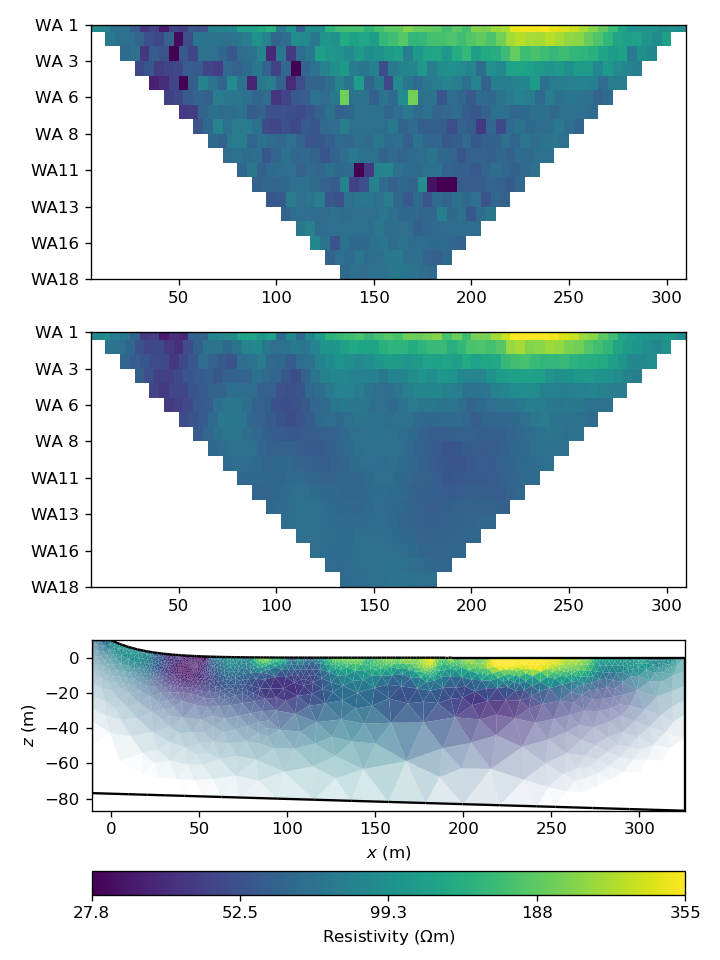

In [58]:
# Plot data of app.res., synthetic data of app.res. from inverted model, and result.
ert.showResultAndFit()
fig=plt.gcf();ax=plt.gca();
fig.set_size_inches(6,8)
fig.tight_layout()